### Project:
* #### Building a Predictive Model for given Image to identify real or fake according to features(pixels) using CNN + ANN neural network

### Training Process

* #### Images Dataset
    * Collect Images
    * Take the Images in Class folders (Binary/Multi-Class)
    * Split the data into Train & Test folders having Same number of classes along with images
  
* #### Prepping the images for the CNN
    * Reading Train, Test folder images
    
* #### Build CNN+ANN Architecture
    * CNN
        * Convolution Layer
        * Pooling Layer
        * Flatten
    * Fully Connected Layer (Flatten Out + ANN)

Dataset : 

### 0. Images Dataset

* **Considered Available Dataset from Kaggle & Added in Input Section for this Notebook**

* **Changing Working Directory to Input Dataset Folder**

In [1]:
import os

os.chdir("/kaggle/input/deepfake-and-real-images/Dataset")

In [2]:
# Folders

os.listdir()

['Validation', 'Test', 'Train']

* We got the images in Train, Validation & Test Folders with Real & Fake Classes , which is required format of CNN
    - Here subfolder names are considered as class names

In [3]:
# Checking images folders

for folder in ['Train', 'Test']:
    print("Folder: ", folder)
    print("Subfolder:", os.listdir(folder))

Folder:  Train
Subfolder: ['Fake', 'Real']
Folder:  Test
Subfolder: ['Fake', 'Real']


In [4]:
# Checking number of images in folders

for folder in ['Train', 'Test']:
    print("Folder:", folder)
    classes = ['Fake','Real']
    for cls in classes:
        print(f"{cls}:", len(os.listdir(folder+"/"+cls)))
    print()

Folder: Train
Fake: 70001
Real: 70001

Folder: Test
Fake: 5492
Real: 5413



Bar chart showing equal class distribution (70,001 each) of 'Real' and 'Fake' images in the training dataset.


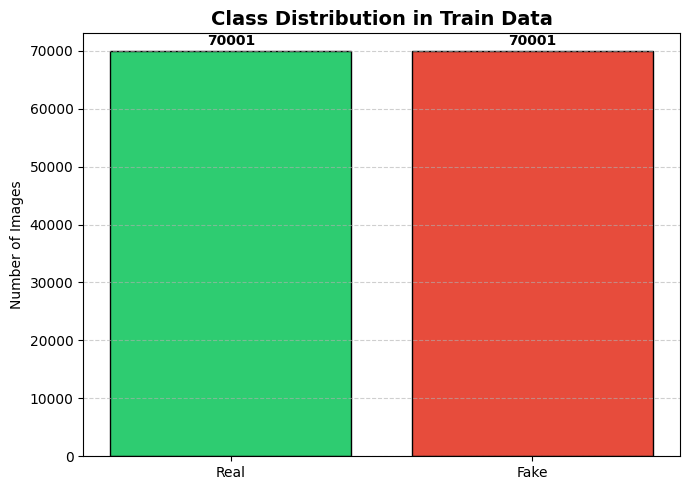

In [5]:
import matplotlib.pyplot as plt

# Predefined counts from earlier output
counts = {'Real': 70001, 'Fake': 70001}
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(7, 5))
bars = plt.bar(counts.keys(), counts.values(), color=colors, edgecolor='black')

# Add labels above bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{int(bar.get_height())}', ha='center', fontsize=10, fontweight='bold')

plt.title('Class Distribution in Train Data', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, max(counts.values()) + 3000)
plt.tight_layout()
plt.show()


Bar chart showing class distribution in test data with 5,413 'Real' and 5,492 'Fake' images.


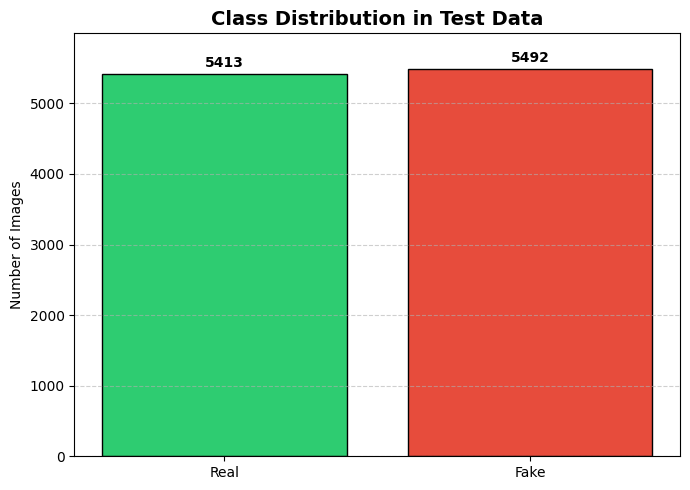

In [6]:
import matplotlib.pyplot as plt

# Predefined counts from earlier output
counts = {'Real': 5413, 'Fake': 5492}
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(7, 5))
bars = plt.bar(counts.keys(), counts.values(), color=colors, edgecolor='black')

# Add labels above bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{int(bar.get_height())}', ha='center', fontsize=10, fontweight='bold')

plt.title('Class Distribution in Test Data', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, max(counts.values()) + 500)
plt.tight_layout()
plt.show()


* We have balanced images count in both classes

Displays the first 10 image filenames from the 'Train/Real' class folder.



In [7]:
# Images in a Class Folder

os.listdir("Train/Real")[0:10]

['real_58276.jpg',
 'real_36415.jpg',
 'real_1646.jpg',
 'real_51062.jpg',
 'real_69849.jpg',
 'real_16868.jpg',
 'real_63819.jpg',
 'real_35789.jpg',
 'real_60328.jpg',
 'real_16642.jpg']

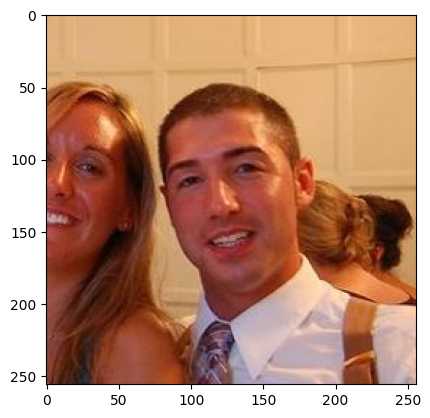

In [8]:
# Display of one image in folder

import matplotlib.image as mpimg

plt.imshow(mpimg.imread("Train/Real/real_34.jpg"))

### 1. Prepping Images for CNN

* **Loading Train and Test folder Images along with class names from Data Folder**

Imports the `image_dataset_from_directory` utility from Keras to load images directly from a directory structure.


In [9]:
# Keras module for reading image files from a folder
from keras.utils import image_dataset_from_directory

Loads images from the "Train" folder into batches of 128 with binary labels and resizes them to 256x256.


In [10]:
train_data = image_dataset_from_directory("Train", image_size=(256, 256), label_mode='binary', batch_size=128)
# batch size hyp param will help us to send number of images in batches for training

Found 140002 files belonging to 2 classes.


**Loading Test Data**
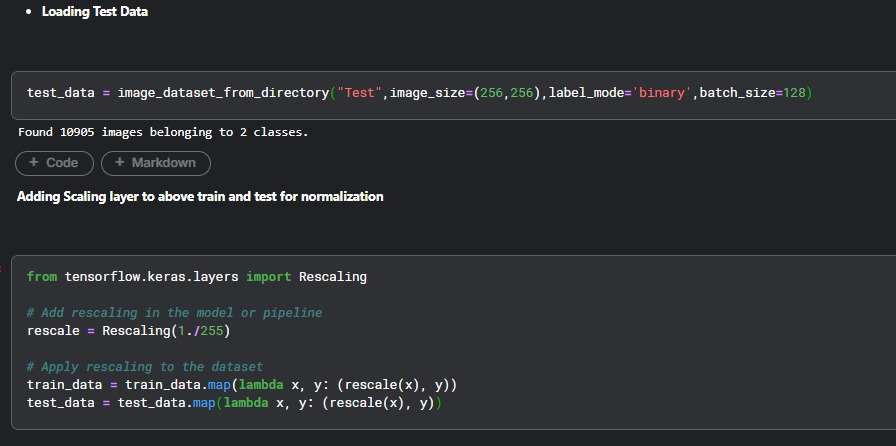

In [11]:
test_data = image_dataset_from_directory("Test", image_size=(256, 256), label_mode='binary', batch_size=128)


Found 10905 files belonging to 2 classes.


In [12]:
from tensorflow.keras.layers import Rescaling

# Add rescaling in the model or pipeline
rescale = Rescaling(1./255)

# Apply rescaling to the dataset
train_data = train_data.map(lambda x, y: (rescale(x), y))
test_data = test_data.map(lambda x, y: (rescale(x), y))

### 2. Model

* Building CNN (to Extract Image Features) +ANN (Classification) Architecture
    * Below are the layers for each Network
    * CNN
        * Convolution Layer
        * Pooling Layer
        * Flatten Layer
    * ANN @ Fully Connected Layer

* **Model Architecture:**
    - The model will contain the following Layers:
        - Convolutional Layers followed by MaxPooling Layers.
        - The Flatten layer to flatten the output of the convolutional layer.
        - Then we will have fully connected layers followed by the output of the flattened layer.
        - The final layer is the output layer which has the activation function sigmoid to classify the results into two classes.
        
    Note: To handle Overfitting , we can given kernel regularizer parameter (l1 or l2) or dropout layers

**CNN**

In [13]:
# Python Modules

import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Flatten, Dense
# from keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

* **Model Intialization**

In [14]:
cnn = Sequential(name='DeepFakeImageClassification')

* **Convolution Layer**

    * Filtering image with different filters

        params

            filters, kernel_size, kernel_regulaizer, stride size, input shape
            activation

        Note:

        * Padding is another param where we can send the original image size through the entire convolution , it will add an extra pixel to the input image

        * relu is used to deal with non-linearity in the convolution

In [15]:
cnn.add(Conv2D(input_shape=(256,256,3), filters = 32, kernel_size=(3,3), activation='relu', strides=(2,2), name='Conv1'))
cnn.summary()

Model: "DeepFakeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 127, 127, 32)        │             896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

* Output image size = (w-f+2p/s)+1

        here w(width) = 256, f(kernel_size) = 3, p(padding) = 0 (used to balance filter on image), s(stride) = 2

        applying above we will get 127*127*32

- weights/params = ((kernel_size x previous filters) x current filters) + bias (no of current filters)

            kernel_size = (3,3)
            previous filters = 3 (channels)
            current filters = 32
            bias = 32

* **Pooling**

    * Getting max pixel values from convolution feature maps

        params:

            pool_size, strides

Dropout Layer (optional)

We can use dropout function for conv+pool layer to drop some neurons going over fitting

Dropout is used when we hava e complex network

Droput will take out the least effective neurons

In [16]:
cnn.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool1'))
cnn.add(Dropout(0.2))
cnn.summary()

Model: "DeepFakeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 127, 127, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

* output image size = (w-f/s)+1

      here w(width) = 127, f(kernel_size) = 2, s(stride) = 1

* no weights & biases

* **Adding Extra Convolution+Pooling Layer (Optional) - To control the Flatten Output**

In [17]:
cnn.add(Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), activation='relu', name='Conv2'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool2'))
cnn.add(Dropout(0.2))

In [18]:
cnn.summary()

Model: "DeepFakeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 127, 127, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 62, 62, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 61, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,520 (21.56 KB)

 Trainable params: 5,520 (21.56 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
cnn.add(Conv2D(filters=8, kernel_size=(2,2), activation='relu', name='Conv3'))
cnn.add(MaxPool2D(pool_size=(2,2), name='Pool3'))
cnn.add(Dropout(0.25))

* **Flatten Layer**

In [20]:
cnn.add(Flatten(name='Flatten'))

In [21]:
cnn.summary()

Model: "DeepFakeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 127, 127, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 62, 62, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 60, 60, 8)           │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 30, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 7200)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,040 (23.59 KB)

 Trainable params: 6,040 (23.59 KB)

 Non-trainable params: 0 (0.00 B)

**ANN**

* **Fully Connected Layer**

    Input to the ANN is from the Flatten Layer output

* Adding Hidden Layers for ANN

Adds fully connected (`Dense`) layers to the CNN model with ReLU activation and `random_uniform` kernel initializer. These layers reduce the feature dimensions in stages: 4096 → 2048 → 1024 → 512.

- `Dense(units=...)` defines the number of neurons in the layer.
- `activation='relu'` ReLU is an activation function that sets negative inputs to 0 and keeps positive ones unchanged, helping speed up learning and avoid vanishing gradients.
- `kernel_initializer='random_uniform'` initializes the weights randomly from a uniform distribution to break symmetry and speed up convergence.

In [22]:
cnn.add(Dense(kernel_initializer='random_uniform', activation='relu', units=4096))
cnn.add(Dense(kernel_initializer='random_uniform', activation='relu', units=2048))
cnn.add(Dense(kernel_initializer='random_uniform', activation='relu', units=1024))
cnn.add(Dense(kernel_initializer='random_uniform', activation='relu', units=512))

* **Output Layer**

In [23]:
cnn.add(Dense(activation='sigmoid', units=1))

# Units - Output neurons, activation - sigmoid for binary classes - generates probability

In [24]:
cnn.summary()

Model: "DeepFakeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 127, 127, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 62, 62, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 60, 60, 8)           │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 30, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      29,495,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,515,481 (154.55 MB)

 Trainable params: 40,515,481 (154.55 MB)

 Non-trainable params: 0 (0.00 B)

* **Model Compile Parameters**

Compiles the CNN model using the Adam optimizer and binary crossentropy loss, while tracking accuracy, F1 score, precision, and recall as evaluation metrics.

Adam is an optimizer that adapts learning rates using momentum and past gradients, making training faster and more stable.  



In [25]:
cnn.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy',
                                                                tf.keras.metrics.F1Score(),
                                                                tf.keras.metrics.Precision(),
                                                                tf.keras.metrics.Recall()])

### 3. Training Model

* **These CNN+ANN models will take huge time to run based on number of parameter training**

* While training images data , based on training params, we need to take small number of epochs first

* We can also control the cpu cores used by fit method, using hyper parameter **workers=-1** (means consider all cores available for faster execution)

* We can also add call backs
    - Callbacks are the special utilities or functions that are executed during training at given stages of the training procedure. Callbacks can help you to visualize training progress, stopping for no improvements and saving better results.

In [26]:
from keras.callbacks import  ModelCheckpoint


MC = ModelCheckpoint(
    '/kaggle/working/deepfake/cnn.keras', # You also can provide full path to the folder you want to save your model to
    monitor='val_loss',  # Monitor other things like val_accuracy or accuracy 
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)

**Note:** For this Data Cnn Each Epoch Takes approx 1.30 min time

In [27]:
cnn.fit(train_data, epochs=50, validation_data=test_data, callbacks=[MC]) # callbacks=[ES] for early stopping

# No need of ytrain/ytest , because class names will taken from given images folder names
# We can also give model checkpoints for fit method

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6942 - f1_score: 0.6677 - loss: 0.5816 - precision: 0.6766 - recall: 0.7502
Epoch 1: val_loss improved from inf to 0.48998, saving model to /kaggle/working/deepfake/cnn.keras
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 236s 207ms/step - accuracy: 0.6943 - f1_score: 0.6677 - loss: 0.5815 - precision: 0.6767 - recall: 0.7503 - val_accuracy: 0.7486 - val_f1_score: 0.6634 - val_loss: 0.4900 - val_precision: 0.7354 - val_recall: 0.7707
Epoch 2/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8678 - f1_score: 0.6680 - loss: 0.2992 - precision: 0.8539 - recall: 0.8882
Epoch 2: val_loss did not improve from 0.48998
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 68s 62ms/step - accuracy: 0.8678 - f1_score: 0.6680 - loss: 0.2991 - precision: 0.8540 - recall: 0.8882 - val_accuracy: 0.7494 - val_f1_score: 0.6637 - val_loss: 0.4917 - val_precision: 0.7542 - val_recall: 0.7345
Epoch 3/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.90

* We got good accuracy on both train and validation

### 4. Model Performance Visualization

* **Loss**

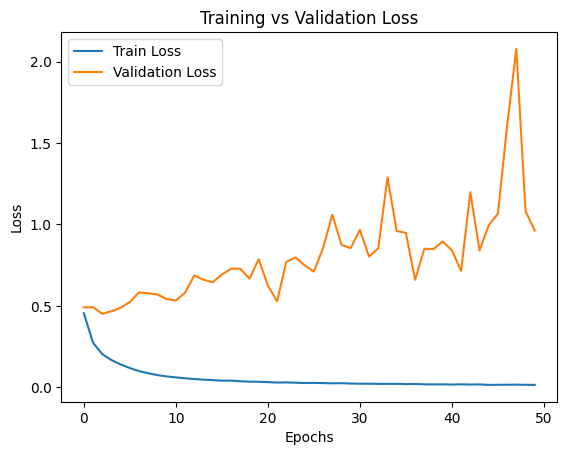

In [28]:
# Get number of epochs from training history
epochs = range(len(cnn.history.history['loss']))

# Plot training and validation loss
plt.plot(epochs, cnn.history.history['loss'], label="Train Loss")
plt.plot(epochs, cnn.history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

* **Performance**

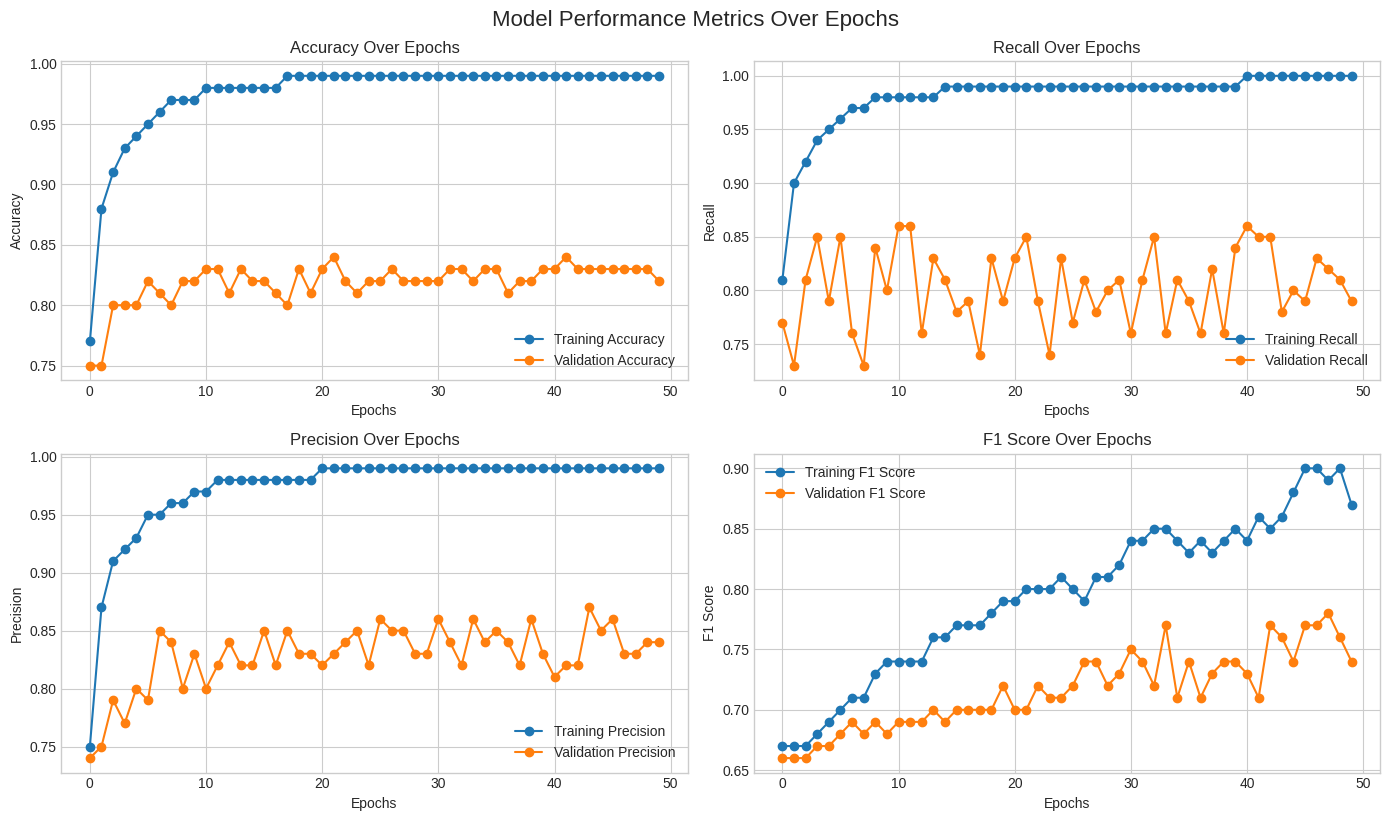

In [29]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')  # Cleaner style

epochs = np.arange(len(cnn.history.history['accuracy']))

# Accuracy
train_acc = [round(val, 2) for val in cnn.history.history['accuracy']]
val_acc = [round(val, 2) for val in cnn.history.history['val_accuracy']]

# Precision
train_pre = [round(val, 2) for val in cnn.history.history['precision']]
val_pre = [round(val, 2) for val in cnn.history.history['val_precision']]

# Recall
train_rec = [round(val, 2) for val in cnn.history.history['recall']]
val_rec = [round(val, 2) for val in cnn.history.history['val_recall']]

# F1 Score
train_f1 = [round(val, 2) for val in cnn.history.history['f1_score']]
val_f1 = [round(val, 2) for val in cnn.history.history['val_f1_score']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

metrics = {
    "Accuracy Over Epochs": (train_acc, val_acc, "Accuracy"),
    "Recall Over Epochs": (train_rec, val_rec, "Recall"),
    "Precision Over Epochs": (train_pre, val_pre, "Precision"),
    "F1 Score Over Epochs": (train_f1, val_f1, "F1 Score")
}

for ax, (title, (train_vals, val_vals, ylabel)) in zip(axes.flat, metrics.items()):
    ax.plot(epochs, train_vals, label=f"Training {ylabel}", marker='o')
    ax.plot(epochs, val_vals, label=f"Validation {ylabel}", marker='o')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Model Performance Metrics Over Epochs", fontsize=16, y=1.02)
plt.show()


In [30]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # Make sure to install tabulate via pip if not already installed

# Get number of epochs
epochs = np.arange(len(cnn.history.history['accuracy']))

# Build a DataFrame
metrics_df = pd.DataFrame({
    "Epoch": epochs + 1,
    "Train Accuracy": cnn.history.history['accuracy'],
    "Val Accuracy": cnn.history.history['val_accuracy'],
    "Train Precision": cnn.history.history['precision'],
    "Val Precision": cnn.history.history['val_precision'],
    "Train Recall": cnn.history.history['recall'],
    "Val Recall": cnn.history.history['val_recall'],
    "Train F1 Score": cnn.history.history['f1_score'],
    "Val F1 Score": cnn.history.history['val_f1_score']
}).round(4)

# Display as a pretty table
print(tabulate(metrics_df.head(10), headers='keys', tablefmt='grid'))


+----+---------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------------+----------------+
|    |   Epoch |   Train Accuracy |   Val Accuracy |   Train Precision |   Val Precision |   Train Recall |   Val Recall |   Train F1 Score |   Val F1 Score |
+====+=========+==================+================+===================+=================+================+==============+==================+================+
|  0 |       1 |           0.7731 |         0.7486 |            0.7535 |          0.7354 |         0.8119 |       0.7707 |           0.6667 |         0.6634 |
+----+---------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------------+----------------+
|  1 |       2 |           0.8808 |         0.7494 |            0.8672 |          0.7542 |         0.8994 |       0.7345 |           0.6676 |         0.6637 |
+----+---------+------------------+-----------

### 5. Real time Prediction
   * **Prediction on given Images**

**Loading Saved Better Performance Model from Model Checkpoint**

In [31]:
import os
os.makedirs("/kaggle/working/deepfake", exist_ok=True)


In [32]:
model = tf.keras.models.load_model("/kaggle/working/deepfake/cnn.keras")

In [33]:
model.save("/kaggle/working/deepfake/cnn.keras")


In [34]:
# Writing a Function for prediction of given image

import cv2
import numpy as np

def classify(frame):
    # Converting Image Size to Cnn Input Size
    img=cv2.resize(frame,(256,256))
    
    #scaling to 0 to 1 range
    if(np.max(img)>1):
        img = img/255.0
        
    img = np.array([img])
    prediction = model.predict(img)[0] # will predict probability
    print("Predicted Probability:", round(prediction[0],2))
    if prediction>=0.5: # Taking thumb rule of 0.5 probability for confirmation of fake or real
        out = 1
    else:
        out = 0
    # Taking Class Names & Numbers for Prediction from train data generator
    classes = ['Fake','Real']
    # mapping out class index number with class name
    cls = classes[out] 
    
    return cls # output class name

* **Taking Sample Images from Test Images given**

In [35]:
import glob

images = glob.glob("/kaggle/input/images-for-predictions/images for prediction//*")

In [36]:
images

['/kaggle/input/images-for-predictions/images for prediction/real_144.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/fake_181.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/real_25.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/fake_78.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/real_123.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/real_63.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/fake_122.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/real_5317.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/fake_56.jpg',
 '/kaggle/input/images-for-predictions/images for prediction/fake_44.jpg']

* **Applying above detect function on Images**

Given Image:



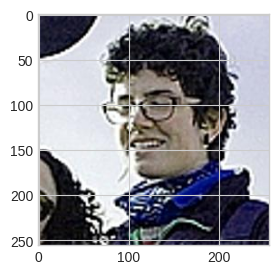


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Predicted Probability: 0.91
Prediction Class: Real

Given Image:



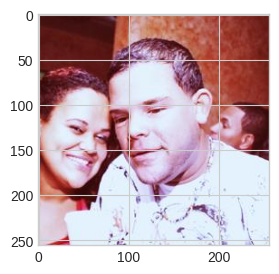


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Probability: 0.01
Prediction Class: Fake

Given Image:



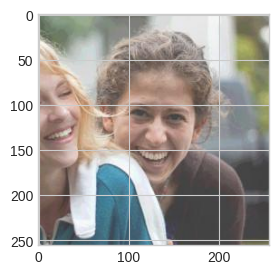


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Probability: 0.98
Prediction Class: Real

Given Image:



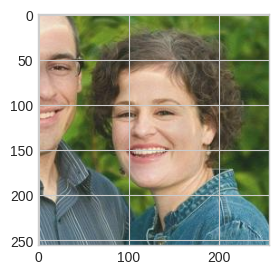


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Probability: 0.0
Prediction Class: Fake

Given Image:



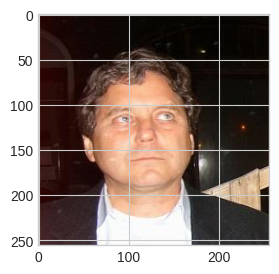


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Probability: 0.99
Prediction Class: Real

Given Image:



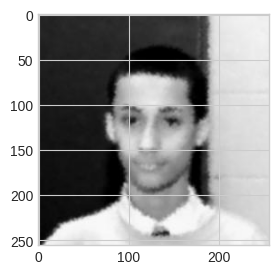


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Probability: 0.99
Prediction Class: Real

Given Image:



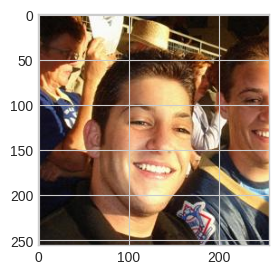


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Probability: 0.01
Prediction Class: Fake

Given Image:



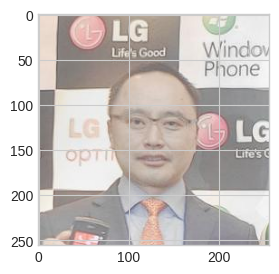


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Probability: 0.98
Prediction Class: Real

Given Image:



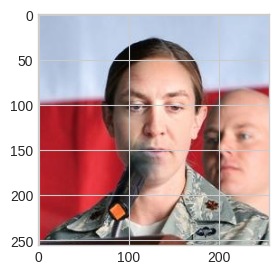


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Probability: 0.0
Prediction Class: Fake

Given Image:



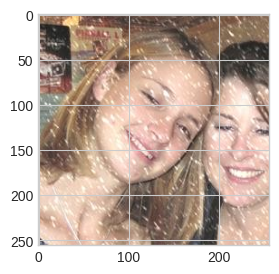


Original Class: Images For Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Probability: 0.48
Prediction Class: Fake



In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # to read image in array

# Looping through each image and applying classify function
for img in images:
    # Reading image
    image = mpimg.imread(r'{}'.format(img))
    print("Given Image:")
    print()
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    print()
    print("Original Class:",img.split("/")[4].split("_")[0].title())
    out = classify(image) # prediction function
    print("Prediction Class:",out)
    print()
    print("=================================================================")

* Out of 10 Images we got 10 Correct predictions

**Notes:**
* We can increase model performance by
    - changing epochs,
    - batch size &
    - hyp param tuning (conv+pool layers adding, filters, kernel sizes, strides, ANN Hidden Layers, etc..)